In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions
import networkx as nx 

In [2]:
''' helper functions'''

def find_nodes(m, smart):
    '''fine nodes in functional group'''
    FGs=[]
    for x in m.GetSubstructMatches(Chem.MolFromSmarts(smart)):
        FGs.append(x)
    return FGs


def replace_with_FG(G, FG_nodes, rep):
    '''merge nodes into one'''    
    for c in range(len(FG_nodes)):
        try:
            for i in range(1,len(FG_nodes[c])):
                G = nx.contracted_nodes(G, FG_nodes[c][0], FG_nodes[c][i])
        except:
            continue
    
    return G

def relabel_FG_nodes(G, FG_nodes, label):
    '''change name of node to identify FG'''
    for c in range(len(FG_nodes)):
        atomic_num = nx.get_node_attributes(G, 'atomic_num')
        atomic_num.update({FG_nodes[c][0]: label})
        nx.set_node_attributes(G, atomic_num, 'atomic_num')
       
    return G

def mol_to_nx(mol):
    '''converts RDKit mol object into a networkx graph'''
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   formal_charge=atom.GetFormalCharge(),
                   chiral_tag=atom.GetChiralTag(),
                   hybridization=atom.GetHybridization(),
                   num_explicit_hs=atom.GetNumExplicitHs(),
                   is_aromatic=atom.GetIsAromatic())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
    return G

def nx_to_mol(G):
    '''converts networkx graph into RDKit mol object'''
    mol = Chem.RWMol()
    atomic_nums = nx.get_node_attributes(G, 'atomic_num')
    chiral_tags = nx.get_node_attributes(G, 'chiral_tag')
    formal_charges = nx.get_node_attributes(G, 'formal_charge')
    node_is_aromatics = nx.get_node_attributes(G, 'is_aromatic')
    node_hybridizations = nx.get_node_attributes(G, 'hybridization')
    num_explicit_hss = nx.get_node_attributes(G, 'num_explicit_hs')
    node_to_idx = {}
    for node in G.nodes():
        a=Chem.Atom(atomic_nums[node])
        a.SetChiralTag(chiral_tags[node])
        a.SetFormalCharge(formal_charges[node])
        a.SetIsAromatic(node_is_aromatics[node])
        a.SetHybridization(node_hybridizations[node])
        a.SetNumExplicitHs(num_explicit_hss[node])
        idx = mol.AddAtom(a)
        node_to_idx[node] = idx
    bond_types = nx.get_edge_attributes(G, 'bond_type')
    for edge in G.edges():
        first, second = edge
        ifirst = node_to_idx[first]
        isecond = node_to_idx[second]
        bond_type = bond_types[first, second]
        mol.AddBond(ifirst, isecond, bond_type)
    Chem.SanitizeMol(mol)
    return mol

In [3]:
# Load SMILES of molecules to search over
df = pd.read_csv('protease_only_id_smiles_IC50.csv')

smiles = df['InChI'].tolist()

df = df[df['IC50'].notna()]
df['IC50'] = df['IC50'].apply(lambda x: float(str(x).replace('>','').replace('<','')))


print(f'{len(smiles)} molecules to search')

9552 molecules to search


In [4]:
df = pd.read_csv('ReplacementGroups.csv')
named_smarts=list(zip(df['name'].tolist(),df['smarts'].tolist(),df['map'].tolist()))
print(f'{len(named_smarts)} functional groups to search')

118 functional groups to search


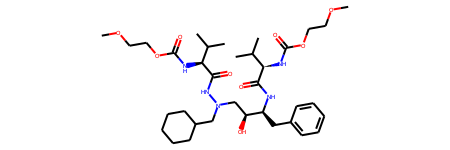

In [9]:
# choose which molecule to plot
n=2

# make mol object and plot
m = Chem.MolFromSmiles(smiles[n])
m

MOLECULE: COCCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CN(CC1CCCCC1)NC(=O)[C@@H](NC(=O)OCCOC)C(C)C
N atoms: 49


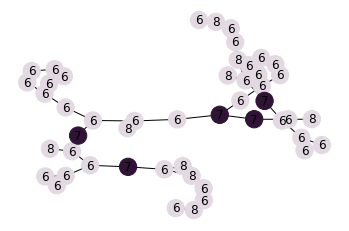

109: carbomyl, [C](N)(O)(=O):  2
110: amide, [C](N)(=O):  2
162: phenyl, c1ccccc1:  1
170: cyclohexane, C1CCCCC1:  1
205: ether-end group, [CH3]O[CH2]:  2
206: iso-butyl, [CH]([CH3])([CH3]):  2


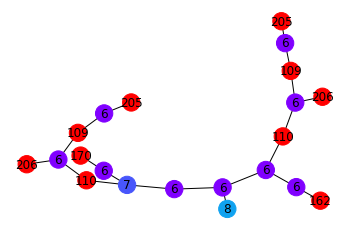

N nodes: 21


In [10]:
print(f'MOLECULE: {smiles[n]}')
m = Chem.MolFromSmiles(smiles[n])
G = mol_to_nx(m)

### plot initial graph ###
print(f'N atoms: {len(G.nodes)}')

pos = nx.spring_layout(G, 0.2, iterations=50)
atomic_num=nx.get_node_attributes(G,'atomic_num')
nx.draw_networkx_labels(G, pos, labels=atomic_num)

atomic_num=[x[1] for x in atomic_num.items()]
nx.draw(G, pos, node_color=atomic_num, cmap=plt.cm.twilight)
plt.show()


### make functional group replacements ###    
replaced_nodes=[]

for o, rep in enumerate(named_smarts):

    nAtoms= m.GetNumAtoms()
    nodes=find_nodes(m, rep[1])

    # check to make sure atom wasn't used previously in a functional group
    rn_only = [x[0] for x in replaced_nodes]
    replaced_nodes_flattened  = [val for sublist in rn_only for val in sublist]
    replaced_nodes_flattened = [val for sublist in replaced_nodes_flattened for val in sublist]

    # remove nodes that have already been transformed into a functional group
    if nodes != []:
        use_nodes=[]
        for ii, no in enumerate(nodes):
            if set(no).intersection(set(replaced_nodes_flattened)) == set():
                use_nodes.append(no)    
                
        # do actual replacement 
        if use_nodes != []:
            G=replace_with_FG(G, use_nodes, rep)
            print(f'{int(rep[2])}: {rep[0]}, {rep[1]}:  {len(use_nodes)}')
            replaced_nodes.append((use_nodes, rep[2]))

# relabel replaced nodes for easier viewing in plot
for nodes in replaced_nodes:   
    G=relabel_FG_nodes(G, nodes[0], int(nodes[1]))


### plot coarsened graph ###  
pos = nx.spring_layout(G, 0.2, iterations=50)
atomic_num=nx.get_node_attributes(G,'atomic_num')
nx.draw_networkx_labels(G, pos, labels=atomic_num)

'''color according to atomic number
   with replaced nodes colored red'''
node_colors=[]
for a in atomic_num.items():
    if a[1] >= 100:
        node_colors.append(15)
    elif a[1] == 16:
        node_colors.append(9)
    else:
        node_colors.append(a[1])

atomic_num=[x[1] for x in atomic_num.items()]
nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.rainbow)
plt.show()
print(f'N nodes: {len(G.nodes)}')
